# A real data example

In our paper, we use six real datasets and here we take the "Concrete" dataset as an example and compare the coverage, width and the choice of parameters by EFCP and VFCP.

In [43]:
source("cqr_function.R")

alpha=0.1
nrep=100

dim = c("concrete")

evaluations <- expand.grid(1:nrep, dim, c("efficient", "valid"))
no_eval <- nrow(evaluations)
mtry_mat <- ntree_mat <- beta_mat <- cqr_method_mat <- width_mat <- cov_mat <- data.frame(number = rep(0, no_eval), 
                                   rep = evaluations[,1], 
                                   dim = evaluations[,2],
                                   method = evaluations[,3])
colnames(width_mat) <- colnames(cov_mat) <- c("number", "rep", "dim", "method")


for(idx in 1:nrow(evaluations)){
  set.seed(idx)
  d <- evaluations[idx, 2]  
  
  if (d =="protein"){
    
    protein=as.matrix(read.csv("CASP.csv",header=TRUE))
    X_full=protein[,2:9]
    Y_full=protein[,1]
    
    
    
  }else if (d=="blog"){
    
    blog=as.matrix(read.csv("blogData_train.csv",header=FALSE))
    X_full=blog[,1:280]
    Y_full=blog[,281]


  }else if (d=="concrete"){
    concrete=as.matrix(read.csv("concrete.csv",header=FALSE,sep=","))
    X_full=concrete[,1:8]
    Y_full=concrete[,9]
    


  }else if (d=="news"){
    news=as.matrix(read.csv("OnlineNewsPopularity.csv",header=FALSE))
    X_full=news[,1:59]
    Y_full=news[,60]

    
  }else if (d=="kernel"){
    kernel=as.matrix(read.csv("sgemm_product.csv",header=FALSE))
    X_full=kernel[,1:14]
    Y_full=apply(kernel[,15:18],1,mean)

    
  }else if (d=="superconduct"){
    superconduct=as.matrix(read.csv("train.csv",header=FALSE))
    X_full=superconduct[,1:81]
    Y_full=superconduct[,82]
  }
  
  subSampleSize = 1000; 
  rows=sample(nrow(X_full))
  X_sample = X_full[rows[1:subSampleSize],]
  Y_sample = Y_full[rows[1:subSampleSize]]
  X=X_sample[1:768,]
  X0=X_sample[769:1000,]
  Y=Y_sample[1:768]
  Y0=Y_sample[769:1000]
  
  
  width_mat[idx,3] <- cov_mat[idx, 3] <- d
  method <- evaluations[idx, 3]
  width_mat[idx,4] <- cov_mat[idx, 4] <- method
  width_mat[idx, 2] <- cov_mat[idx, 2] <- evaluations[idx, 1]
  
  if(method == "valid"){
    split <- c(1/2, 1/2)
  } else {
    split <- 1/2
  }  
  
  p = dim(X0)[2]
  beta_grid <- seq(1e-03, 4, length = 10)*alpha
  mtry_grid <- unique(ceiling(seq(1/10, 1, length = 10)*p))
  ntree_grid <- seq(100, 400, by = 100)
  

  
  tmp =   try(conf_CQR_reg(X, Y, split = split, beta_grid, mtry_grid, ntree_grid, method = method, alpha = alpha))
  
  while (class(tmp)=="try-error"){
    
    tmp =   try(conf_CQR_reg(X, Y, split = split, beta_grid, mtry_grid, ntree_grid, method = method, alpha = alpha),silent=TRUE)
    
  }
  
  beta_mat[idx,1] = tmp$beta
  ntree_mat[idx,1] = tmp$ntree  
  mtry_mat[idx,1] = tmp$mtry
  cqr_method_mat[idx, 1]= tmp$cqr_method      
  width_mat[idx, 1] <- mean(tmp$pred_set(X0, Y0)[[2]])
  cov_mat[idx, 1] <- mean(tmp$pred_set(X0, Y0)[[1]])
  

  
}

save(n,p,nrep,width_mat,mtry_mat, cov_mat,beta_mat, ntree_mat, cqr_method_mat, evaluations, alpha, file = "concrete-100-repetitions.RData" )

In [44]:
load("concrete-100-repetitions.RData")
par(mfrow = c(1,2))
width_efcp <- width_vfcp <- sd_width_efcp <- sd_width_vfcp <- NULL
for(d in dim){
  TMP <- width_mat[evaluations[,3] == "efficient", ]
  TMP_prime <- TMP[TMP[,3] == d,]
  
  TMP <- width_mat[evaluations[,3] == "valid", ]
  TMP_prime_vfcp <- TMP[TMP[,3] == d,]
  
  
  width_efcp <- c(width_efcp, mean(TMP_prime[,1] ))
  sd_width_efcp <- c(sd_width_efcp, sd(TMP_prime[,1])/sqrt(nrep))
  

  width_vfcp <- c(width_vfcp, mean(TMP_prime_vfcp[,1] ))
  sd_width_vfcp <- c(sd_width_vfcp, sd(TMP_prime_vfcp[,1])/sqrt(nrep))
}

cov_efcp <- cov_vfcp <-sd_cov_efcp <- sd_cov_vfcp <- NULL
for(d in dim){
  TMP <- cov_mat[evaluations[,3] == "efficient", ]
  TMP_prime <- TMP[TMP[,3] == d,]
  cov_efcp <- c(cov_efcp, mean(TMP_prime[,1]))
  sd_cov_efcp <- c(sd_cov_efcp, sd(TMP_prime[,1])/sqrt(nrep))
  
  TMP <- cov_mat[evaluations[,3] == "valid", ]
  TMP_prime <- TMP[TMP[,3] == d,]
  cov_vfcp <- c(cov_vfcp, mean(TMP_prime[,1]))
  sd_cov_vfcp <- c(sd_cov_vfcp, sd(TMP_prime[,1])/sqrt(nrep))
}

#save(dim,width_mat, cov_mat, evaluations, width_efcp, sd_cov_efcp, sd_width_vfcp,sd_width_efcp,width_vfcp, sd_cov_vfcp, cov_efcp, cov_vfcp, file = "real-100-repetitions.RData" )


#plot(dim, width_efcp, type = 'l', ylim = range(c(width_efcp+sd_efcp)), lwd = 2)




In [45]:
message("EFCP average coverage: ",cov_efcp, " average width: ",width_efcp )
message("VFCP average coverage: ",cov_vfcp, " average width: ",width_vfcp )

EFCP average coverage: 0.885560344827586 average width: 17.9864106912337

VFCP average coverage: 0.902370689655172 average width: 19.5369890614671



Compare this to the smallest width 18.19 achieved by QOOB in Table 2 of [Gupta, Kuchibhotla, and Ramdas, 2021](#cite-gupta2019nested).

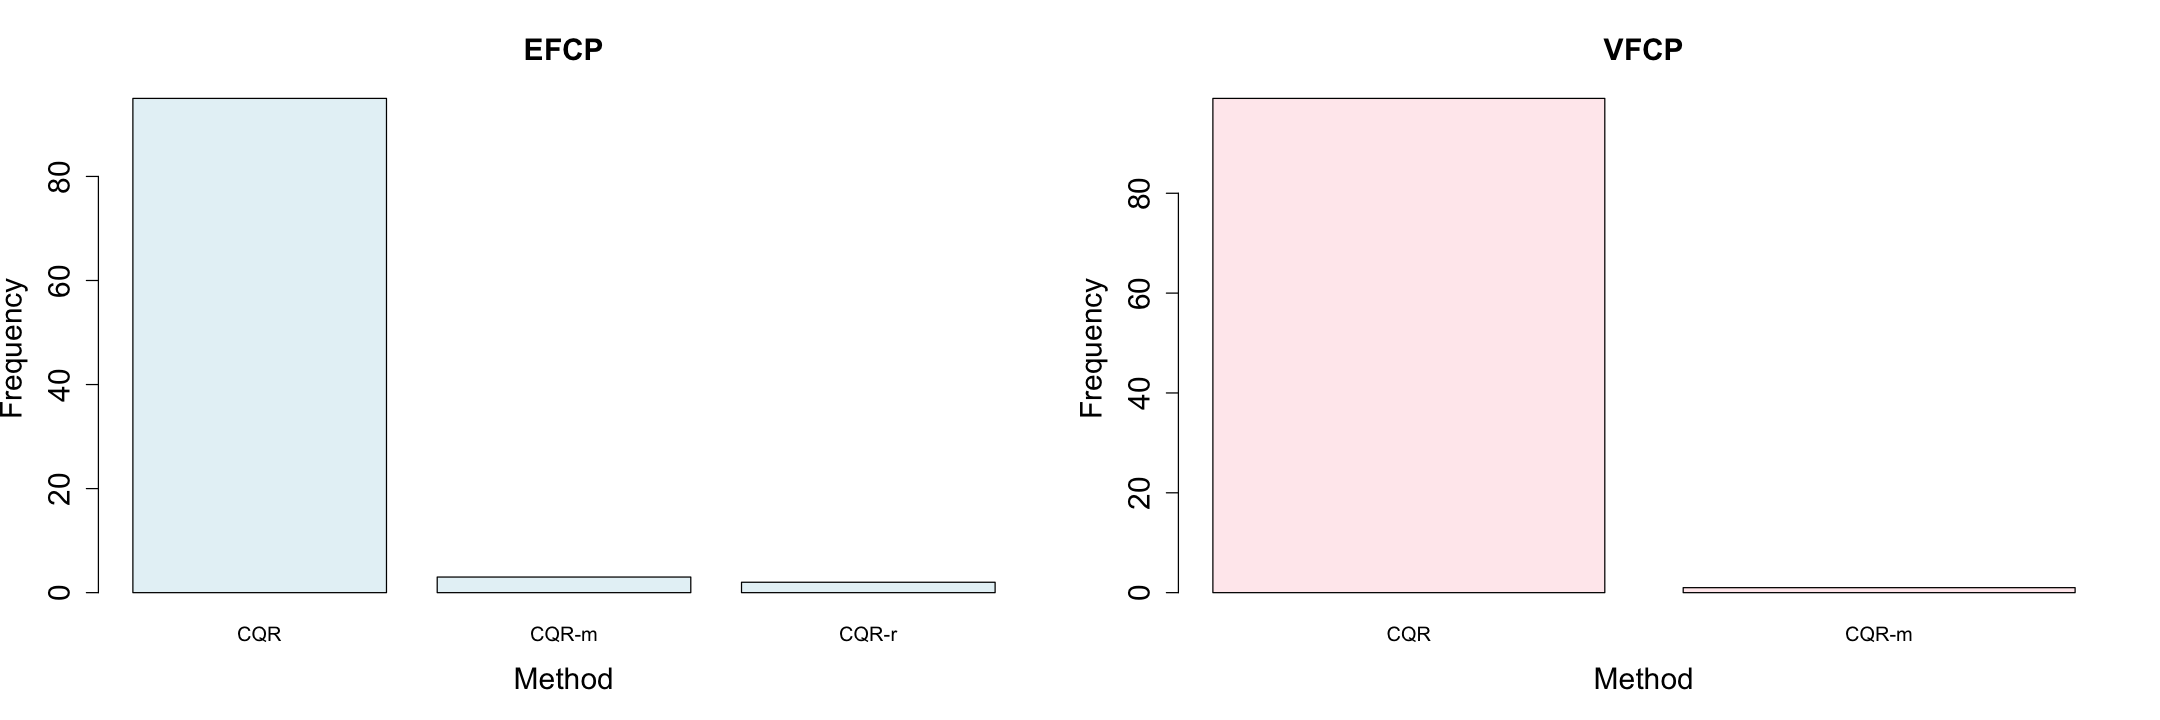

In [46]:
options(repr.plot.width=18, repr.plot.height=6)
par(mfrow=c(1,2))
c1 <- rgb(173,216,230,max = 255, alpha = 80, names = "lt.blue")
c2 <- rgb(255,192,203, max = 255, alpha = 80, names = "lt.pink")

plot(factor(cqr_method_mat[evaluations[,3] == "valid",1]),col=c1, main="EFCP",cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,xlab="Method",ylab="Frequency")
#legend("right", legend=c("EFCP", "VFCP"),fill=c(c1, c2))
plot(factor(cqr_method_mat[evaluations[,3] == "efficient",1]),col=c2, main="VFCP",cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,xlab="Method",ylab="Frequency")

The above plot shows that among the three methods for conformal quantile regression: CQR,CQR-m and CQR-r, both EFCP and VFCP use CQR most, which agrees with the findings in [Sesia, Candes, 2020](#cite-sesia2020comparison).

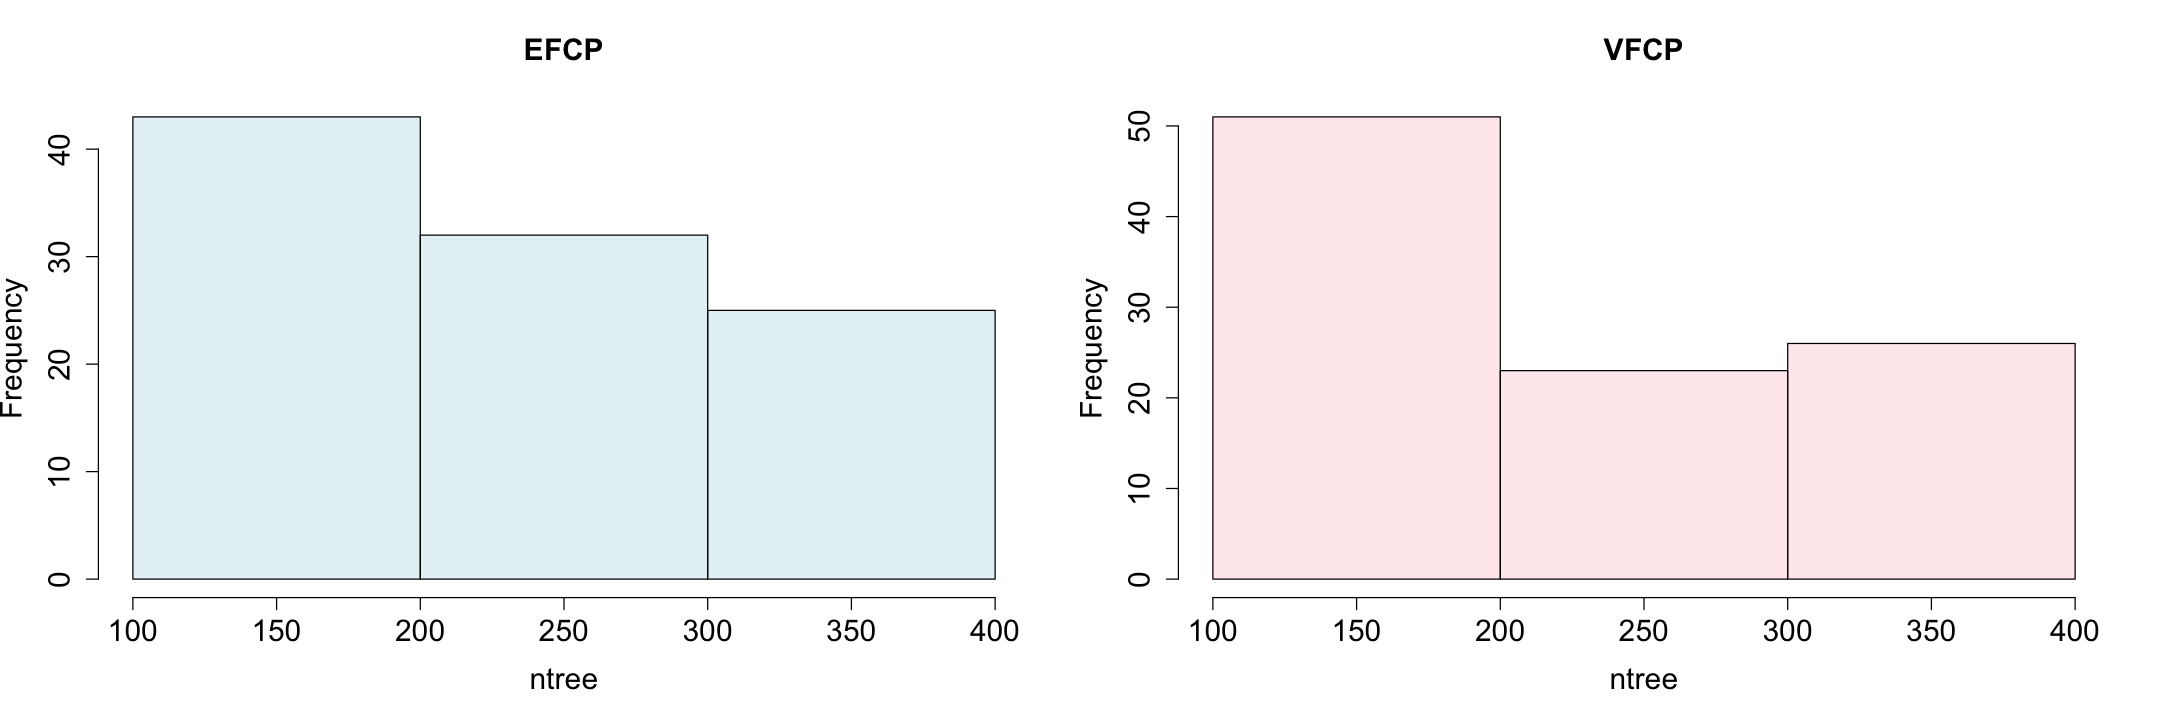

In [47]:
par(mfrow=c(1,2))
hist(ntree_mat[evaluations[,3] == "efficient",1],col=c1,breaks=ntree_grid,main="EFCP",xlab="ntree",cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(ntree_mat[evaluations[,3] == "valid",1],col=c2,breaks=ntree_grid,main="VFCP",xlab="ntree",cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
#legend("left", legend=c("EFCP", "VFCP"), fill=c(c1, c2))

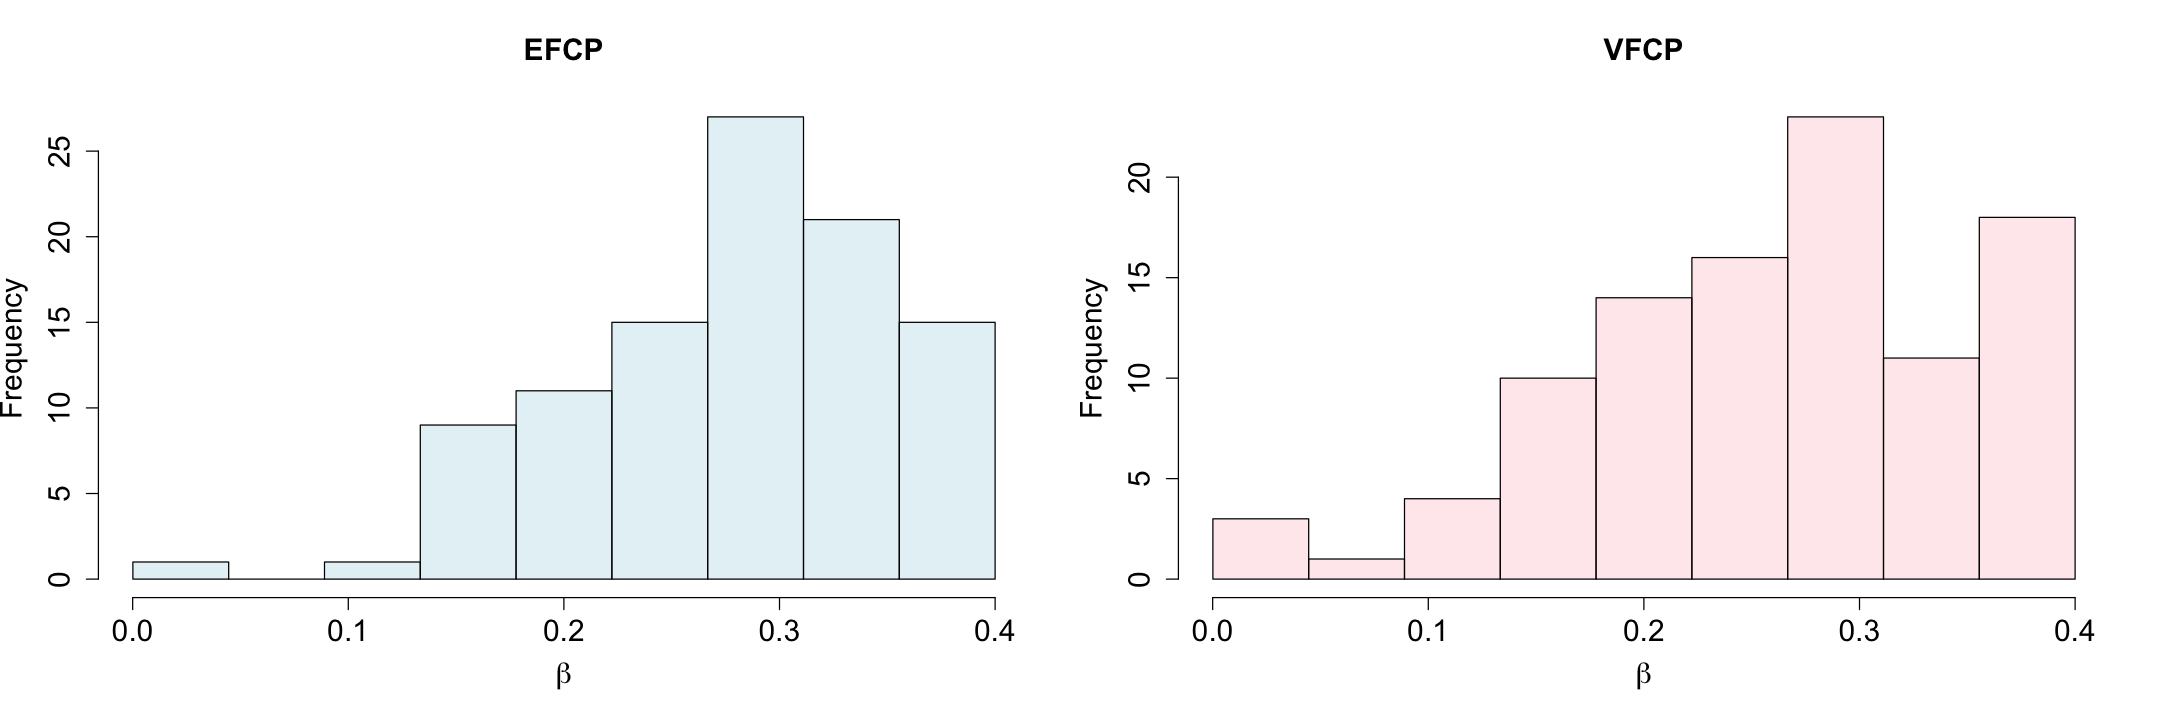

In [48]:
par(mfrow=c(1,2))
hist(beta_mat[evaluations[,3] == "efficient",1],col=c1,breaks=beta_grid,main="EFCP",xlab=expression(beta),cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(beta_mat[evaluations[,3] == "valid",1],col=c2,breaks=beta_grid,main="VFCP",xlab=expression(beta),cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

This, in some sense, supports the decision in [Gupta, Kuchibhotla, and Ramdas, 2021](#cite-gupta2019nested) to use the nominal quantile level $\beta = 2\alpha$.

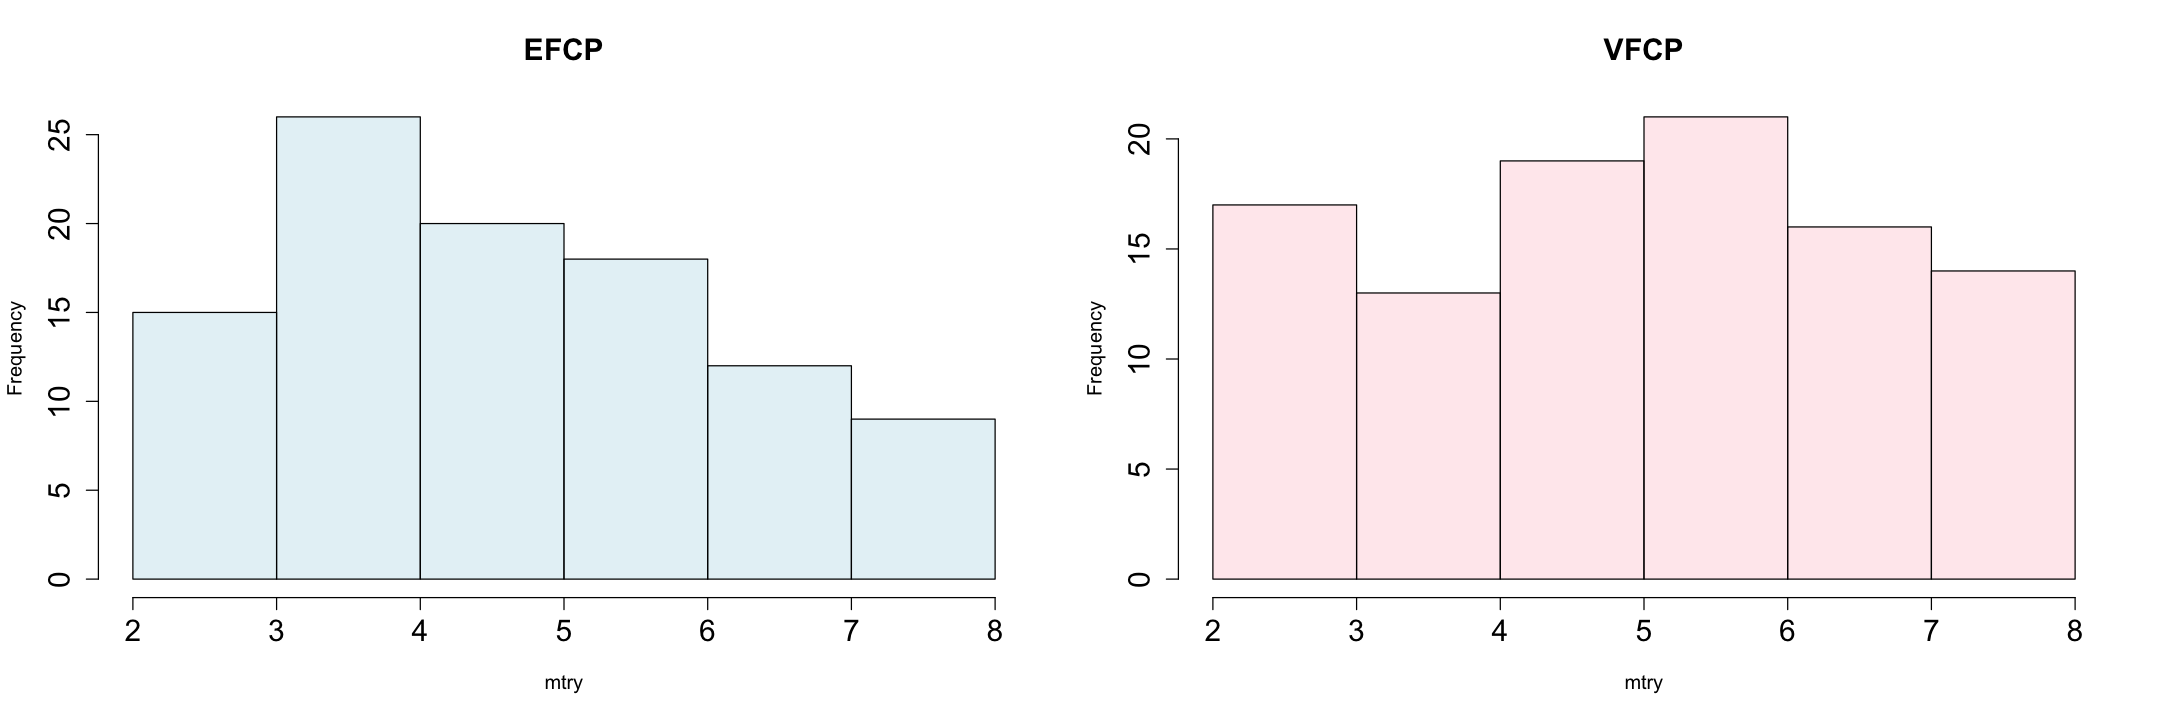

In [49]:
par(mfrow=c(1,2))
hist(mtry_mat[evaluations[,3] == "efficient",1],col=c1, main="EFCP",xlab="mtry", cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(mtry_mat[evaluations[,3] == "valid",1],col=c2, main="VFCP",xlab="mtry", cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

The usage of mtry is pretty spread out for both EFCP and VFCP.

<!--bibtex

@article{sesia2020comparison,
  title={{A comparison of some conformal quantile regression methods}},
  author={Sesia, Matteo and Cand{\`e}s, Emmanuel J},
  journal={Stat},
  volume={9},
  number={1},
  pages={e261},
  year={2020},
  publisher={Wiley Online Library}


@article{gupta2019nested,
  title={Nested conformal prediction and quantile out-of-bag ensemble methods},
  author={Gupta, Chirag and Kuchibhotla, Arun K and Ramdas, Aaditya K},
  journal={Pattern Recognition (accepted). Preprint at arXiv:1910.10562},
  year={2021}
}

-->



<!--bibtex

@article{sesia2020comparison,
  title={A comparison of some conformal quantile regression methods},
  author={Sesia, Matteo and Cand{\`e}s, Emmanuel J},
  journal={Stat},
  volume={9},
  number={1},
  pages={e261},
  year={2020},
  publisher={Wiley Online Library}
}


@article{gupta2019nested,
  title={Nested conformal prediction and quantile out-of-bag ensemble methods},
  author={Gupta, Chirag and Kuchibhotla, Arun K and Ramdas, Aaditya K},
  journal={Pattern Recognition},
  year={2021}
}

-->



# References

<a id="cite-sesia2020comparison"/><sup><a href=#ref-1></a><a href=#ref-2>[^]</a></sup>Sesia, Matteo and Cand&egrave;s, Emmanuel J. 2020. _A comparison of some conformal quantile regression methods_. 

<a id="cite-gupta2019nested"/><sup><a href=#ref-1></a><a href=#ref-2>[^]</a></sup>Gupta, Chirag and Kuchibhotla, Arun K and Ramdas, Aaditya K. 2021. _Nested conformal prediction and quantile out-of-bag ensemble methods_. 
